# Predicting alcohol content of red Vinho Verde wines

We begin by importing necessary packages along with our cleaned dataframe.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from helpers import *

sns.set_style('whitegrid')

In [2]:
clean_df = pd.read_csv('cleaned_data.csv')

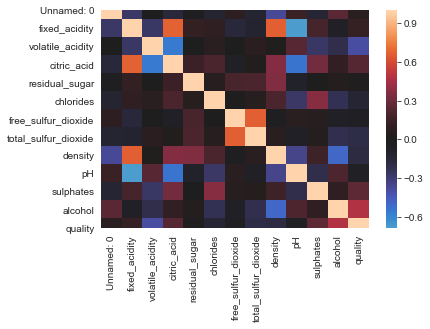

In [3]:
sns.heatmap(clean_df.corr(),center=0);

We observe no multicollinearity and proceed to normalize and standardize the data. The result of these transformations is loaded below.

In [4]:
main_df = pd.read_csv('standardized_data.csv')

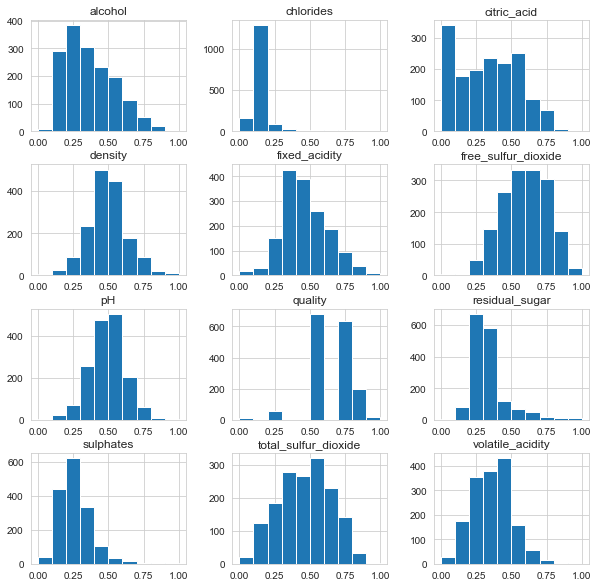

In [5]:
main_df.hist(figsize  = (10, 10));

## Initial Model in statsmodels

In [6]:
# Create the formula of form "outcome ~ predictor_1+predictor_2+...+predictor_n"
data_ols = main_df
outcome = 'alcohol'
predictors = data_ols.drop('alcohol', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

model = ols(formula= formula, data=data_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                alcohol   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     338.6
Date:                Mon, 02 Dec 2019   Prob (F-statistic):               0.00
Time:                        23:09:11   Log-Likelihood:                 1506.8
No. Observations:                1599   AIC:                            -2990.
Df Residuals:                    1587   BIC:                            -2925.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.1416      0.031     -4.637      0.000      -0.202      -0.082
fixed_acidity            0.8501      0.036     23.661      0.000       0.780       0.921
volatile_acidity         0.1235      0.024      5.165      0.000       0.077       0.170
citric_acid              0.1146      0.019      6.132      0.000       0.078       0.151
residual_sugar           0.5704      0.022     26.020      0.000       0.527       0.613
chlorides               -0.1053      0.034     -3.111      0.002      -0.172      -0.039
free_sulfur_dioxide     -0.0056      0.025     -0.223      0.823      -0.055       0.044
total_sulfur_dioxide    -0.0781      0.023     -3.360      0.001      -0.124      -0.033
density                 -1.3205      0.031    -42.199      0.000      -1.382      -1.259
pH                       0.7358      0.031     23.488      0.000       0.674       0.797
sulphates                0.2731      0.024     11.192      0.000       0.225       0.321
quality                  0.1773      0.019      9.251      0.000       0.140       0.215
==============================================================================
Omnibus:                      141.656   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.028
Skew:                           0.634   Prob(JB):                     9.21e-52
Kurtosis:                       4.386   Cond. No.                         41.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note that $p_\text{free sulfur dioxide} > \alpha$ so we will eliminate this predictor from the model. However, free sulfur dioxide is accounted for to some degree in total sulfur dioxide so we don't lose much by eliminating this predictor.

In [7]:
main_df.drop(labels='free_sulfur_dioxide',axis=1,inplace=True)

## Feature Engineering

We imagine there will exist interactions between physiochemical properties that are related to each other in a chemical sense. 

pH is a measure of the concentration of total acidity in a solution. We therefore predict there will exist interactions between pH and all three measures of acid, any base (chloride, albeit a weak base), and also quality because we know wines without acidity are considered flat.

Similarly, we predict there will exist interactions between all sulfur-containing predictors because they all are measures of sulfur-containing compounds. Also, sulfur-containing compounds are generally known to be smelly, which could impact the perceived quality of the wine, so we check for interactions between total sulfur and quality.

Lastly, we predict there will be interactions between density and residual sugar, as the more sugar dissolved in the wine, the greater the density will be.

regression coeff 1 is  [-1.00771164]
regression coeff 2 is  [-0.61149341]


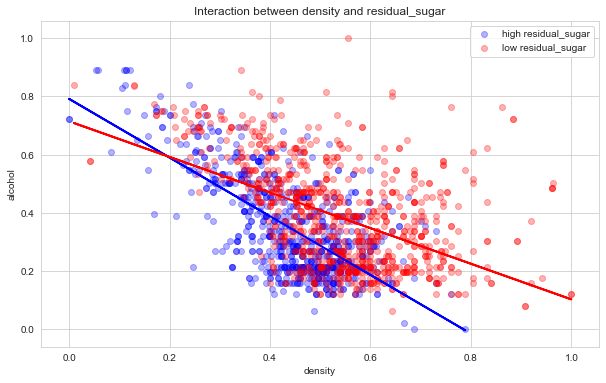

In [8]:
# Cutoff at 0.3 because residual sugar's median is ~0.3
high_sug = main_df[main_df.residual_sugar < 0.3]
low_sug = main_df[main_df.residual_sugar >= 0.3]

# This function is from the helpers module
check_interaction(high_sug,low_sug,'density','alcohol','residual_sugar');

The intersecting lines above suggest there is significant interaction between residual sugar and density. We therefore engineer a column in our dataset called density_res_sugar.

We ran similar tests for all interactions we believed would exist, as outlined above this plot. We'll add the engineered features to our datafram that exhibit interactions.

In [9]:
# Add engineered features that exhibit interactions

main_df['ph_fixed_a'] = main_df.fixed_acidity * main_df.pH
main_df['ph_volatile_a'] = main_df.volatile_acidity * main_df.pH
main_df['ph_citric_a'] = main_df.citric_acid * main_df.pH
main_df['ph_chlorides'] = main_df.chlorides * main_df.pH
main_df['ph_quality'] = main_df.quality * main_df.pH
main_df['res_sug_quality'] = main_df.quality * main_df.residual_sugar
main_df['res_sug_density'] = main_df.density * main_df.residual_sugar
main_df['tsd_quality'] = main_df.quality * main_df.total_sulfur_dioxide

In [10]:
# Run the same code for the linear regression as above, but for the newly updated df
data_ols = main_df
outcome = 'alcohol'
predictors = data_ols.drop('alcohol', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

model = ols(formula= formula, data=data_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                alcohol   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     230.2
Date:                Mon, 02 Dec 2019   Prob (F-statistic):               0.00
Time:                        23:09:12   Log-Likelihood:                 1570.2
No. Observations:                1599   AIC:                            -3102.
Df Residuals:                    1580   BIC:                            -3000.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.1862      0.084     -2.214      0.027      -0.351      -0.021
fixed_acidity            1.2097      0.075     16.131      0.000       1.063       1.357
volatile_acidity         0.2420      0.086      2.806      0.005       0.073       0.411
citric_acid              0.2084      0.073      2.836      0.005       0.064       0.353
residual_sugar           0.3736      0.094      3.964      0.000       0.189       0.558
chlorides               -0.1759      0.090     -1.963      0.050      -0.352      -0.000
total_sulfur_dioxide    -0.2342      0.054     -4.365      0.000      -0.339      -0.129
density                 -1.4525      0.047    -30.823      0.000      -1.545      -1.360
pH                       1.1221      0.137      8.181      0.000       0.853       1.391
sulphates                0.2506      0.024     10.307      0.000       0.203       0.298
quality                  0.0027      0.091      0.030      0.976      -0.176       0.181
ph_fixed_a              -0.7766      0.134     -5.790      0.000      -1.040      -0.514
ph_volatile_a           -0.2844      0.166     -1.715      0.087      -0.610       0.041
ph_citric_a             -0.2019      0.140     -1.441      0.150      -0.477       0.073
ph_chlorides             0.2293      0.220      1.044      0.297      -0.201       0.660
ph_quality               0.1169      0.135      0.868      0.385      -0.147       0.381
res_sug_quality         -0.0101      0.114     -0.089      0.929      -0.233       0.213
res_sug_density          0.3727      0.098      3.805      0.000       0.181       0.565
tsd_quality              0.2569      0.084      3.049      0.002       0.092       0.422
==============================================================================
Omnibus:                       92.471   Durbin-Watson:                   1.617
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.967
Skew:                           0.419   Prob(JB):                     1.24e-37
Kurtosis:                       4.360   Cond. No.                         206.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note that many of these engineered features have $p > \alpha = 0.5$ and therefore we must remove them. We tested different combinations of these features to arrive at just two that remain in the final model. 

In [11]:
final_df = main_df.drop(labels=['res_sug_quality','ph_quality','quality','tsd_quality','ph_volatile_a','ph_chlorides','ph_citric_a'],axis=1)

# Final Model

In [12]:
data_ols = final_df
outcome = 'alcohol'
predictors = data_ols.drop('alcohol', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

model = ols(formula= formula, data=data_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                alcohol   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     348.0
Date:                Mon, 02 Dec 2019   Prob (F-statistic):               0.00
Time:                        23:09:12   Log-Likelihood:                 1522.3
No. Observations:                1599   AIC:                            -3021.
Df Residuals:                    1587   BIC:                            -2956.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.1360      0.040     -3.419      0.001      -0.214      -0.058
fixed_acidity            1.3332      0.057     23.460      0.000       1.222       1.445
volatile_acidity         0.0553      0.023      2.389      0.017       0.010       0.101
citric_acid              0.0968      0.018      5.267      0.000       0.061       0.133
residual_sugar           0.3799      0.059      6.389      0.000       0.263       0.497
chlorides               -0.1146      0.033     -3.429      0.001      -0.180      -0.049
total_sulfur_dioxide    -0.0844      0.014     -6.031      0.000      -0.112      -0.057
density                 -1.5445      0.047    -33.047      0.000      -1.636      -1.453
pH                       1.1425      0.051     22.421      0.000       1.043       1.242
sulphates                0.3095      0.023     13.271      0.000       0.264       0.355
ph_fixed_a              -0.8986      0.097     -9.231      0.000      -1.090      -0.708
res_sug_density          0.4135      0.100      4.132      0.000       0.217       0.610
==============================================================================
Omnibus:                       93.998   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.365
Skew:                           0.396   Prob(JB):                     7.58e-42
Kurtosis:                       4.488   Cond. No.                         88.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We are satisfied with this model as the final model of our unpenalized linear regression. We will now test this against Ridge and Lasso penalized models.

# Penalized Models

In [13]:
X = main_df
y = main_df[["alcohol"]]

# A short function to compare sklearn ridge and lasso models to unpenalized linear model
compare_fits(X,y,test_size=0.2, alpha=0.5)

---------------------------------------
Train Error Ridge Model alcohol    0.016091
dtype: float64
Test Error Ridge Model alcohol    0.003881
dtype: float64


Train Error Lasso Model alcohol    39.228061
dtype: float64
Test Error Lasso Model alcohol    8.357997
dtype: float64


Train Error Unpenalized Linear Model alcohol    2.405667e-29
dtype: float64
Test Error Unpenalized Linear Model alcohol    6.317736e-30
dtype: float64


We see that both penalized linear regression models perform more poorly than the unpenalized model. We therefore will stick with what we had originally and will continue to test our assumptions about linear models.

## Testing Assumptions

We must test the homoscedasticity and normal distribution of error of our model to confirm its vailidity. We start with homoscedasticity.

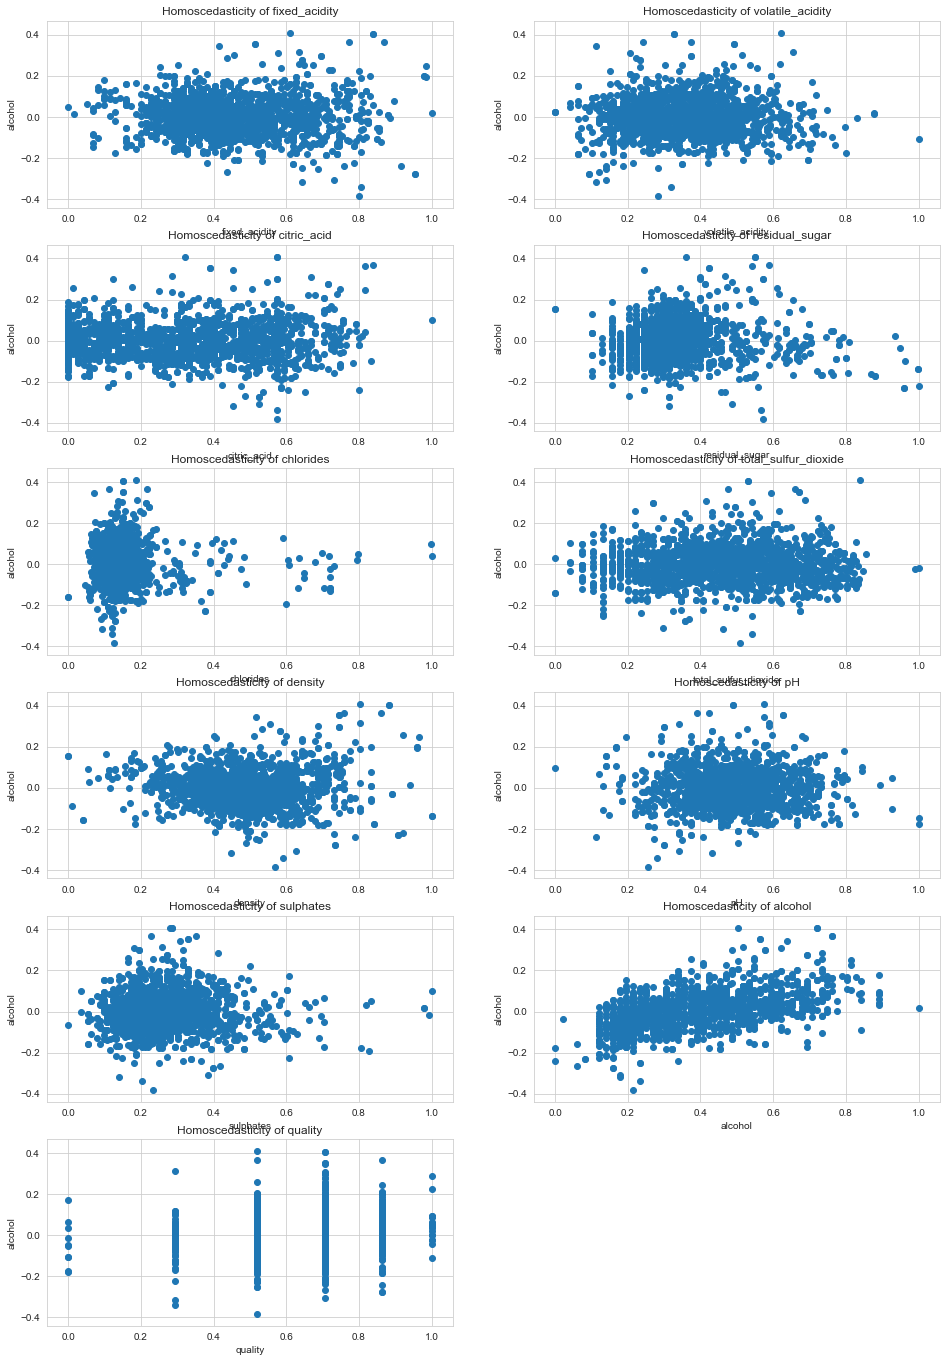

In [14]:
# checking for our model - Homoscedasticity
pred_val = model.fittedvalues.copy()
true_val = main_df['alcohol'].values.copy()
residual = true_val - pred_val

# Instantiate figure
fig = plt.figure(figsize=(16,24))

predictors = main_df.columns
for n in range(1,12):
    ax = plt.subplot(6,2,n)
    ax.scatter(main_df[predictors[n-1]],residual)
    ax.set_xlabel(predictors[n-1]), ax.set_ylabel('alcohol')
    ax.set_title(f'Homoscedasticity of {predictors[n-1]}')

We see that the variance is not completely uniformly distributed. Thus, we must acknowledge that the accuracy of our model is limited to only regions where the variance in all of our predictors is uniformly distributed.

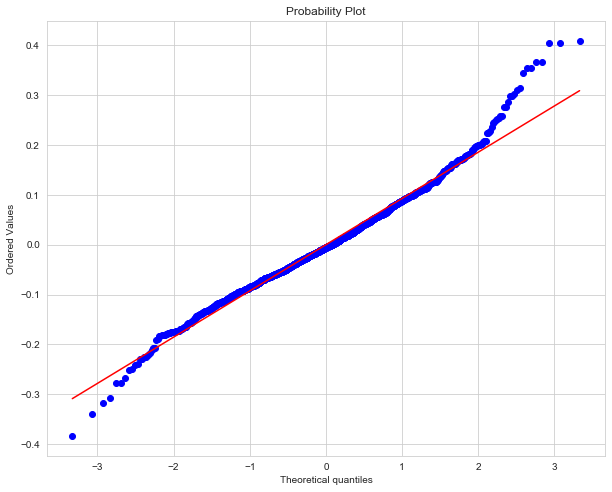

In [15]:
# checking for normality - QQ plot 
import scipy as sp
fig, ax = plt.subplots(figsize=(10,8))
sp.stats.probplot(residual, plot=ax, fit=True);

The deviation of our model from the solid line in the above figure shows us that our model's error is not normally distributed at the extremes. We can only accept predictions from our model within the range where the error is normally distributed.

# Cross Validation

The last thing we will do is to cross-validate our model using k-fold validation in sklearn.

In [16]:
X_cv = main_df.drop('alcohol',axis=1)
y_cv = main_df.alcohol

X_train, X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size=0.20)

linreg = LinearRegression()

linreg.fit(X_train, y_train)
y_hat_test = linreg.predict(X_test)


#Find Error

test_residuals = y_hat_test - y_test

test_mse = mean_squared_error(y_test, y_hat_test)
test_mse

0.009225204793438281

In [17]:
cv_5_results = cross_val_score(linreg, X_cv, y_cv, cv=5, scoring='neg_mean_squared_error')
cv_5_results

array([-0.01004873, -0.01748191, -0.00707487, -0.00678553, -0.00806954])

In [18]:
np.std(cv_5_results)

0.003963305742203271

Very low $\sigma$ of the cross validation tests suggests that our model is quite robust within the regions that we discuss in the model assumptions section.